In [1]:
# !pip install gtts pydub audioop-lts
from gtts import gTTS
from pydub import AudioSegment
import time
import os
import pandas as pd
from datetime import date
import glob
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from moviepy import ImageClip, CompositeVideoClip, AudioFileClip
from pydub.exceptions import CouldntDecodeError
pd.options.display.max_columns = 100
pd.options.display.max_rows = 130
hanzi_font_path = '/System/Library/Fonts/STHeiti Medium.ttc'

# 0. Choose setting

In [ ]:
making_video = True
recording_id_codes = {
    '001': 'full_word_sent',
    '004': 'word_only',
    '012': 'efirst_csent',
    '006': 'ecombo',
    '013': 'ccombo_sent',
    '014': 'cinna_sent',
    '015': 'conly_sent',
}
WORD_TYPES = ['combo', 'no combo', 'two word', 'prefix', 'single char', 'suffix', 'abbreviation', 'proper noun']
PHRASE_TYPES = ['phrase', 'sentence', 'part sent', 'phrase_save', 'speak_phrase', 'saying', 'idiom', 'slang', 'signs', 'signs_uncommon']
SENT_TYPES = ['sentence']
types_allowed_map = {'_phrase': PHRASE_TYPES, '': WORD_TYPES, '_sent': SENT_TYPES}
categories_allowed_map = {'animal': ['animal'], '': None}
date_string = date.today().strftime("%m%d")
default_settings = {
    'min_priority': 1, 'max_priority': 4,
    'min_known_english_prompt': 1, 'max_known_english_prompt': 6,
    'min_known_pinyin_prompt': 1, 'max_known_pinyin_prompt': 6,
    'sort_keys': ['category1', 'category2', 'pinyin'],
    'sort_asc': [True, True, True],
    'min_combo_quality': 6,
    'category_type': '',
    'cat1_values_allowed': None,
    'types_allowed_str': '',
    'min_adu': 1,
    'min_per': 1,
    'min_date': '2025-01-01',
    'filename_suffix': '',
}
extra_recordings = [
    ### Refresh on Sep 1, 3
    {
    'recording_id': '012', # efirst p1
    'min_priority': 1, 'max_priority': 1,
    'min_known_english_prompt': 3, 'max_known_english_prompt': 5,
    },
    {
    'recording_id': '012', # efirst p2
    'min_priority': 2, 'max_priority': 2,
    'min_known_english_prompt': 3, 'max_known_english_prompt': 5,
    },
    {
    'recording_id': '012', # efirst p3
    'min_priority': 3, 'max_priority': 3,
    'min_known_english_prompt': 3, 'max_known_english_prompt': 5,
    },
    {
    'recording_id': '012', 'filename_suffix': '_known2', # efirst known2 p1-3
    'min_priority': 1, 'max_priority': 3,
    'min_known_english_prompt': 2, 'max_known_english_prompt': 2,
    },
    {
    'recording_id': '001', # fulle p1
    'min_priority': 1, 'max_priority': 1,
    'min_known_pinyin_prompt': 3, 'max_known_pinyin_prompt': 5,
    },
    {
    'recording_id': '001', # fulle p2
    'min_priority': 2, 'max_priority': 2,
    'min_known_pinyin_prompt': 3, 'max_known_pinyin_prompt': 5,
    },
    {
    'recording_id': '001', # fulle p3
    'min_priority': 3, 'max_priority': 3,
    'min_known_pinyin_prompt': 3, 'max_known_pinyin_prompt': 5,
    },
    {
    'recording_id': '004', # wordonly p1
    'min_priority': 1, 'max_priority': 1,
    'min_known_pinyin_prompt': 3, 'max_known_pinyin_prompt': 5,
    },
    {
    'recording_id': '004', # wordonly p2
    'min_priority': 2, 'max_priority': 2,
    'min_known_pinyin_prompt': 3, 'max_known_pinyin_prompt': 5,
    },
    {
    'recording_id': '004', 'filename_suffix': '_phrase', # phrases p1-2
    'types_allowed_str': '_phrase',
    'min_priority': 1, 'max_priority': 2,
    'min_known_pinyin_prompt': 2, 'max_known_pinyin_prompt': 5,
    },
    {
    'recording_id': '004', 'filename_suffix': '_phrase', # phrases p3
    'types_allowed_str': '_phrase',
    'min_priority': 3, 'max_priority': 3,
    'min_known_pinyin_prompt': 2, 'max_known_pinyin_prompt': 5,
    },
    {
    'recording_id': '006', # combos only
    'min_combo_quality': 4,
    'min_priority': 1, 'max_priority': 2,
    'min_known_english_prompt': 2, 'max_known_english_prompt': 5,
    },
    {
    'recording_id': '015', 'filename_suffix': '_known2', # chinese only
    'min_priority': 1, 'max_priority': 2,
    'min_known_english_prompt': 1, 'max_known_english_prompt': 2,
    },
    # {
    # 'recording_id': '001', 'filename_suffix': '_recentAug15',
    # 'min_date': '2025-08-15',
    # 'min_priority': 1, 'max_priority': 3,
    # 'min_known_english_prompt': 2, 'max_known_english_prompt': 5,
    # },

    ### Refresh TODO
    # pinyin p1
    # TODO - finish

    ###  OLD: not planning to make regularly
    # {
    # 'recording_id': '013',
    # 'min_priority': 1,
    # 'max_priority': 4,
    # 'min_known_english_prompt': 1,
    # 'max_known_english_prompt': 5,
    # 'types_allowed_str': '',
    # 'min_combo_quality': 2,
    # 'category_type': 'animal',
    # 'sort_keys': ['category2', 'quality', 'pinyin'],
    # 'sort_asc': [True, True, True],
    # },
    # {
    # 'recording_id': '014',
    # 'types_allowed_str': '_sent',
    # 'cat1_values_allowed': ['cinna'],
    # 'sort_keys': ['id'],
    # 'sort_asc': [True],
    # },
]
df_all_recordings_tomake = pd.DataFrame(extra_recordings)
for setting_key, setting_default in default_settings.items():
    if setting_key not in df_all_recordings_tomake.columns:
        df_all_recordings_tomake[setting_key] = [setting_default]*len(df_all_recordings_tomake)
    else:
        if setting_key in ['sort_keys', 'sort_asc', 'cat1_values_allowed']:
            df_all_recordings_tomake[setting_key] = df_all_recordings_tomake[setting_key].apply(lambda d: d if isinstance(d, list) else setting_default)
        else:
            df_all_recordings_tomake[setting_key] = df_all_recordings_tomake[setting_key].fillna(setting_default)

df_all_recordings_tomake['recording_id_code'] = df_all_recordings_tomake['recording_id'].map(recording_id_codes)
df_all_recordings_tomake['types_allowed'] = df_all_recordings_tomake['types_allowed_str'].map(types_allowed_map)
df_all_recordings_tomake['categories_allowed'] = df_all_recordings_tomake['category_type'].map(categories_allowed_map)
df_all_recordings_tomake['recording_name'] = df_all_recordings_tomake.apply(lambda x: f"{date_string}_{x['recording_id']}_{x['recording_id_code']}_p{x['min_priority']}_{x['max_priority']}{x['filename_suffix']}", axis=1)
df_all_recordings_tomake

,recording_id,min_priority,max_priority,min_known_english_prompt,max_known_english_prompt,filename_suffix,min_known_pinyin_prompt,max_known_pinyin_prompt,types_allowed_str,min_combo_quality,sort_keys,sort_asc,category_type,cat1_values_allowed,min_adu,min_per,min_date,recording_id_code,types_allowed,categories_allowed,recording_name
0,012,1,1,3.0,5.0,,1.0,6.0,,6.0,"[category1, category2, pinyin]","[True, True, True]",,None,1,1,2025-01-01,efirst_csent,"[combo, no combo, two word, prefix, single cha...",None,0904_012_efirst_csent_p1_1
1,012,2,2,3.0,5.0,,1.0,6.0,,6.0,"[category1, category2, pinyin]","[True, True, True]",,None,1,1,2025-01-01,efirst_csent,"[combo, no combo, two word, prefix, single cha...",None,0904_012_efirst_csent_p2_2
2,012,3,3,3.0,5.0,,1.0,6.0,,6.0,"[category1, category2, pinyin]","[True, True, True]",,None,1,1,2025-01-01,efirst_csent,"[combo, no combo, two word, prefix, single cha...",None,0904_012_efirst_csent_p3_3
3,012,1,3,2.0,2.0,_known2,1.0,6.0,,6.0,"[category1, category2, pinyin]","[True, True, True]",,None,1,1,2025-01-01,efirst_csent,"[combo, no combo, two word, prefix, single cha...",None,0904_012_efirst_csent_p1_3_known2
4,001,1,1,1.0,6.0,,3.0,5.0,,6.0,"[category1, category2, pinyin]","[True, True, True]",,None,1,1,2025-01-01,full_word_sent,"[combo, no combo, two word, prefix, single cha...",None,0904_001_full_word_sent_p1_1
5,001,2,2,1.0,6.0,,3.0,5.0,,6.0,"[category1, category2, pinyin]","[True, True, True]",,None,1,1,2025-01-01,full_word_sent,"[combo, no combo, two word, prefix, single cha...",None,0904_001_full_word_sent_p2_2
6,001,3,3,1.0,6.0,,3.0,5.0,,6.0,"[category1, category2, pinyin]","[True, True, True]",,None,1,1,2025-01-01,full_word_sent,"[combo, no combo, two word, prefix, single cha...",None,0904_001_full_word_sent_p3_3
7,004,1,1,1.0,6.0,,3.0,5.0,,6.0,"[category1, category2, pinyin]","[True, True, True]",,None,1,1,2025-01-01,word_only,"[combo, no combo, two word, prefix, single cha...",None,0904_004_word_only_p1_1
8,004,2,2,1.0,6.0,,3.0,5.0,,6.0,"[category1, category2, pinyin]","[True, True, True]",,None,1,1,2025-01-01,word_only,"[combo, no combo, two word, prefix, single cha...",None,0904_004_word_only_p2_2
9,004,1,2,1.0,6.0,_phrase,2.0,5.0,_phrase,6.0,"[category1, category2, pinyin]","[True, True, True]",,None,1,1,2025-01-01,word_only,"[phrase, sentence, part sent, phrase_save]",None,0904_004_word_only_p1_2_phrase


# 1. Load data

In [3]:
cols_keep = [
    'id', 'chinese', 'pinyin', 'english',
    'type', 'priority', 'known', 'known_pinyin_prompt', 'known_english_prompt',
    'phonetic', 'category1', 'category2', 'quality',
    'word1', 'word1_english', 'word2', 'word2_english', 'word3', 'word3_english', 'word4', 'word4_english',
    'sentence', 'sentence_pinyin', 'sentence_english', 'date', 'cat1', 'per', 'adu']
sheet_url = 'https://docs.google.com/spreadsheets/d/1pw9EAIvtiWenPDBFBIf7pwTh0FvIbIR0c3mY5gJwlDk/edit#gid=0'
sheet_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
df = pd.read_csv(sheet_url)[cols_keep]
df = df.dropna(subset=['chinese', 'english'])
df['known_english_prompt'] = df['known_english_prompt'].fillna(6)
df['known_pinyin_prompt'] = df['known_pinyin_prompt'].fillna(6)
df['quality'] = df['quality'].fillna(5)
df['per'] = df['per'].fillna(5)
df['adu'] = df['adu'].fillna(5)
df['date'] = df['date'].fillna('2025-01-02')
print(df.shape)
df.head()

(5060, 28)


,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1,per,adu
0,4,组合,zǔ hé,combination,combo,1.0,5.0,5.0,5.0,NaN,general,NaN,2.0,组,set,适,suitable,NaN,NaN,NaN,NaN,这个组合在比赛中获得了第一名。,Zhège zǔhé zài bǐsài zhōng huòdé le dì yī míng.,This group won first place in the competition.,2025-01-02,NaN,5.0,5.0
1,1375,排序,pái xù,sort,combo,1.0,5.0,5.0,5.0,NaN,electronics,NaN,2.0,安排,to arrange,顺序,sequence,NaN,NaN,NaN,NaN,请帮我排序这些文件,Qǐng bāng wǒ páixù zhèxiē wénjiàn,Please help me sort these files,2025-06-08,NaN,5.0,5.0
2,3991,通知,tōng zhī,notification;notify,combo,1.0,5.0,5.0,3.0,NaN,electronics,NaN,2.0,通过,to get through,知识,knowledge,NaN,NaN,NaN,NaN,我收到了一个通知,Wǒ shōu dào le yī gè tōngzhī,I received a notice,2025-07-09,daily add,5.0,5.0
3,703,适应,shì yìng,to get used to;to adapt,combo,1.0,5.0,5.0,5.0,NaN,feeling,NaN,3.0,适合,to suit,应该,should,NaN,NaN,NaN,NaN,你适应新环境了吗,Nǐ shìyìng xīn huánjìng le ma,Have you adapted to the new environment,2025-01-02,NaN,5.0,5.0
4,941,以来,yǐ lái,since (previous event),combo,1.0,5.0,5.0,5.0,NaN,time,NaN,3.0,以前,before,来,to come,NaN,NaN,NaN,NaN,我认识你以来都很开心,Wǒ rènshi nǐ yǐlái dōu hěn kāixīn,I've been happy since I met you,2025-01-02,NaN,5.0,5.0


In [4]:
# Check for duplicates. fix if there are any
df_dups = df['chinese'].value_counts()
df_dups = df_dups[df_dups > 1]
df_dups = df[df['chinese'].isin(df_dups.index)].sort_values(['chinese'])
df_dups

,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1,per,adu


# 2. Select data

In [5]:
def filter_by_recording_type(df, recording_id):
    """Filter the DataFrame based on the recording type."""
    if recording_id in ['004', '005', '010', '014']:
        return df.dropna(subset=['chinese', 'pinyin', 'english'])
    elif recording_id in ['001', '009', '002', '012', '015']:
        return df.dropna(subset=['sentence', 'sentence_english'])
    elif recording_id == '006':
        return df.dropna(subset=['word1', 'word1_english', 'word2', 'word2_english'])
    elif recording_id == '013':
        return df.dropna(subset=['word1', 'word1_english', 'word2', 'word2_english', 'sentence'])
    elif recording_id == '007':
        return df[df['date'] >= '2025-07-15'].dropna(subset=['sentence', 'sentence_english'])
    elif recording_id == '008':
        return df[df['date'] >= '2025-07-15']
    else:
        raise ValueError("Invalid recording ID")

# Which data to use this time?
# 
dfs_by_recording = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    dfs_by_recording[rrow['recording_name']] = df[
            (df['priority'] <= rrow['max_priority']) &
            (df['priority'] >= rrow['min_priority']) &
            (df['known_english_prompt'] >= rrow['min_known_english_prompt']) &
            (df['known_english_prompt'] <= rrow['max_known_english_prompt']) &
            (df['known_pinyin_prompt'] >= rrow['min_known_pinyin_prompt']) &
            (df['known_pinyin_prompt'] <= rrow['max_known_pinyin_prompt']) &

            (df['quality'] <= rrow['min_combo_quality']) &
            (df['adu'] >= rrow['min_adu']) &
            (df['per'] >= rrow['min_per']) &
            (df['date'] >= rrow['min_date']) &
            (df['type'].isin(rrow['types_allowed'])) &
            (df['category1'].isin(rrow['categories_allowed']) if rrow['categories_allowed'] is not None else True) &
            (df['cat1'].isin(rrow['cat1_values_allowed']) if rrow['cat1_values_allowed'] is not None else True)
        ]
    dfs_by_recording[rrow['recording_name']] = (filter_by_recording_type(dfs_by_recording[rrow['recording_name']], rrow['recording_id'])
        .sort_values(rrow['sort_keys'], ascending=rrow['sort_asc'],)
        .reset_index(drop=True))
    print(rrow['recording_name'], dfs_by_recording[rrow['recording_name']].shape)

dfs_by_recording[rrow['recording_name']].head(10)

0904_012_efirst_csent_p1_1 (140, 28)
0904_012_efirst_csent_p2_2 (616, 28)
0904_012_efirst_csent_p3_3 (337, 28)
0904_012_efirst_csent_p1_3_known2 (409, 28)
0904_001_full_word_sent_p1_1 (39, 28)
0904_001_full_word_sent_p2_2 (346, 28)
0904_001_full_word_sent_p3_3 (859, 28)
0904_004_word_only_p1_1 (39, 28)
0904_004_word_only_p2_2 (346, 28)
0904_004_word_only_p1_2_phrase (193, 28)
0904_004_word_only_p3_3_phrase (97, 28)
0904_006_ecombo_p1_2 (888, 28)
0904_015_conly_sent_p1_2_known2 (600, 28)


,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1,per,adu
0,1039,标准,biāo zhǔn,standard,combo,1.0,5.0,1.0,2.0,NaN,adjective,NaN,3.0,目标,target,准备,preparation,NaN,NaN,NaN,NaN,这家店的服务很标准,Zhè jiā diàn de fúwù hěn biāozhǔn,The service here is very standard,2025-01-02,NaN,5.0,5.0
1,340,出名,chū míng,famous,combo,2.0,5.0,2.0,2.0,NaN,adjective,NaN,2.0,出,to go out,名,name,NaN,NaN,NaN,NaN,他因为短视频很快出名,Tā yīnwèi duǎn shìpín hěn kuài chūmíng,He became famous quickly because of short videos,2025-01-02,NaN,5.0,5.0
2,1428,大声,dà shēng,loud,combo,2.0,4.0,3.0,2.0,NaN,adjective,NaN,1.0,大,big,声,voice,NaN,NaN,NaN,NaN,请不要大声说话,Qǐng búyào dàshēng shuōhuà,Please do not speak loudly,2025-06-15,NaN,5.0,5.0
3,128,具体,jù tǐ,specific;concrete;definite,combo,1.0,3.0,1.0,2.0,NaN,adjective,NaN,3.0,具,tool,身体,body,NaN,NaN,NaN,NaN,能说得具体一点吗,Néng shuō de jùtǐ yīdiǎn ma,Can you be more specific,2025-01-02,NaN,5.0,5.0
4,1098,难免,nán miǎn,inevitable;hard to avoid,combo,2.0,5.0,2.0,2.0,NaN,adjective,NaN,2.0,难,hard,避免,to avoid,NaN,NaN,NaN,NaN,下雨天迟到很难免,Xiàyǔ tiān chídào hěn nánmiǎn,Being late on rainy days is hard to avoid,2025-01-02,NaN,5.0,5.0
5,1661,顺利,shùn ​lì,smoothly,no combo,1.0,2.0,2.0,2.0,NaN,adjective,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,如果一切顺利我们下周就出发,Rúguǒ yīqiè shùnlì wǒmen xià zhōu jiù chūfā,If everything goes well we will leave next week,2025-01-02,NaN,5.0,5.0
6,2759,脏,zàng,dirty,single char,1.0,5.0,3.0,2.0,NaN,adjective,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,这件衣服太脏了快去洗吧,Zhè jiàn yīfú tài zāng le kuài qù xǐ ba,This piece of clothing is too dirty go wash it,2025-01-02,NaN,5.0,5.0
7,1751,差点儿,chà diǎn er,almost,combo,2.0,2.0,2.0,2.0,NaN,amount,degree,2.0,差,lacking,点,bit,儿,Beijing er,NaN,NaN,我差点儿错过了火车,Wǒ chàdiǎnr cuòguò le huǒchē,I almost missed the train,2025-01-02,NaN,5.0,5.0
8,2849,大概,dà gài,probably,combo,2.0,2.0,1.0,2.0,NaN,amount,degree,3.0,大,big,概念,concept,NaN,NaN,NaN,NaN,他大概晚上七点到,Tā dàgài wǎnshàng qī diǎn dào,He will probably arrive around 7 p.m.,2025-02-10,NaN,5.0,5.0
9,509,非常,fēi cháng,very,combo,1.0,1.0,1.0,1.0,NaN,amount,degree,2.0,非,not,正常,regular,NaN,NaN,NaN,NaN,他非常聪明,tā fēi cháng cōng míng,he is very smart,2025-01-02,NaN,5.0,5.0


In [6]:
def pinyin_to_tones(pinyin):
    """Convert pinyin to tones."""
    pinyin = pinyin.replace('ā', 'a1').replace('á', 'a2').replace('ǎ', 'a3').replace('à', 'a4')
    pinyin = pinyin.replace('ē', 'e1').replace('é', 'e2').replace('ě', 'e3').replace('è', 'e4')
    pinyin = pinyin.replace('ī', 'i1').replace('í', 'i2').replace('ǐ', 'i3').replace('ì', 'i4')
    pinyin = pinyin.replace('ō', 'o1').replace('ó', 'o2').replace('ǒ', 'o3').replace('ò', 'o4')
    pinyin = pinyin.replace('ū', 'u1').replace('ú', 'u2').replace('ǔ', 'u3').replace('ù', 'u4')
    pinyin = pinyin.replace('ü', 'v1').replace('ǘ', 'v2').replace('ǚ', 'v3').replace('ǜ', 'v4')
    tones = []
    for pinyin_oneword in pinyin.split():
        tone = '1'  # Default tone
        for i in range(1, 5):
            if f'{i}' in pinyin_oneword:
                tone = str(i)
                break
        tones.append(tone)
    return tones

for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    if rrow['recording_id'] == '005':
        dfs_by_recording[rrow['recording_name']]['pinyin_tones'] = dfs_by_recording[rrow['recording_name']]['pinyin'].apply(pinyin_to_tones)
        dfs_by_recording[rrow['recording_name']][['pinyin', 'pinyin_tones']]

        # Make pinyin audio
        pinyin_tones = ['1', '2', '3', '4']
        for tone_str in pinyin_tones:
            gTTS(tone_str, lang='en').save(f"audio_files/english/{tone_str}.mp3")

# 3. TTS

In [9]:
def create_tts_file(tts_type, content_str, lang_name, last_timestamp, chinese_char, recording_id):
    if tts_type == 'zh_slow':
        slow_mode = True
    else:
        slow_mode = False

    new_file_path = f"audio_files/{tts_type}/{content_str}.mp3"
    if not os.path.exists(new_file_path):
        # Delete final row file, if exists, since will have to rewrite it
        row_file_path = f"audio_files/rows/{recording_id}/{chinese_char}.mp3"
        if os.path.exists(row_file_path):
            os.remove(row_file_path)
        
        try:
            gTTS(content_str, lang=lang_name, slow=slow_mode).save(new_file_path)
        except:
            # Wait 60 seconds and try again
            print(f"!!!!!!! FAILURE, wait 52 seconds, row{i_row}, {tts_type}, {content_str} !!!!!!!")
            time.sleep(52)
            try:
                gTTS(content_str, lang=lang_name, slow=slow_mode).save(new_file_path)
            except:
                # Wait 60 seconds and try again
                print(f"!!!!!!!!!! FAILURE AGAIN, wait 278 seconds, row{i_row}, {tts_type}, {content_str} !!!!!!!!!!")
                time.sleep(278)
                gTTS(content_str, lang=lang_name, slow=slow_mode).save(new_file_path)
        print(f"{(time.time()-last_timestamp):.3f}s, recid{recording_id}, row{i_row}, {tts_type}, {content_str}")
    else:
        print(f"{(time.time()-last_timestamp):.3f}s, ALREADY EXISTS, recid{recording_id}, row{i_row}, {tts_type}, {content_str}")


for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    for i_row, row in dfs_by_recording[rrow['recording_name']].iterrows():
        create_tts_file(tts_type='zh', content_str=row['chinese'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
        create_tts_file(tts_type='zh_slow', content_str=row['chinese'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
        create_tts_file(tts_type='english', content_str=row['english'], lang_name='en', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
        # create_tts_file(tts_type='zh_tw', content_str=row['chinese'], lang_name='zh-tw', last_timestamp=time.time())
        if rrow['recording_id'] in ['001', '007', '009', '013']:
            create_tts_file(tts_type='zh', content_str=row['sentence'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
            create_tts_file(tts_type='english', content_str=row['sentence_english'], lang_name='en', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
        if rrow['recording_id'] in ['002', '011', '012', '015']:
            create_tts_file(tts_type='zh', content_str=row['sentence'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
        if rrow['recording_id'] in ['006', '013']:
            create_tts_file(tts_type='zh', content_str=row['word1'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
            create_tts_file(tts_type='zh', content_str=row['word2'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
            create_tts_file(tts_type='english', content_str=row['word1_english'], lang_name='en', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
            create_tts_file(tts_type='english', content_str=row['word2_english'], lang_name='en', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
            if not pd.isna(row['word3']):
                create_tts_file(tts_type='zh', content_str=row['word3'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
                create_tts_file(tts_type='english', content_str=row['word3_english'], lang_name='en', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
            if not pd.isna(row['word4']):
                create_tts_file(tts_type='zh', content_str=row['word4'], lang_name='zh-cn', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])
                create_tts_file(tts_type='english', content_str=row['word4_english'], lang_name='en', last_timestamp=time.time(), chinese_char=row['chinese'], recording_id=rrow['recording_id'])

0.000s, ALREADY EXISTS, recid012, row0, zh, 详细
0.000s, ALREADY EXISTS, recid012, row0, zh_slow, 详细
0.000s, ALREADY EXISTS, recid012, row0, english, detailed
0.000s, ALREADY EXISTS, recid012, row0, zh, 请给我详细地址
0.000s, ALREADY EXISTS, recid012, row1, zh, 正常
0.000s, ALREADY EXISTS, recid012, row1, zh_slow, 正常
0.000s, ALREADY EXISTS, recid012, row1, english, normal
0.000s, ALREADY EXISTS, recid012, row1, zh, 一切都很正常
0.000s, ALREADY EXISTS, recid012, row2, zh, 宽
0.000s, ALREADY EXISTS, recid012, row2, zh_slow, 宽
0.000s, ALREADY EXISTS, recid012, row2, english, wide
0.000s, ALREADY EXISTS, recid012, row2, zh, 这条路很宽
0.000s, ALREADY EXISTS, recid012, row3, zh, 窄
0.000s, ALREADY EXISTS, recid012, row3, zh_slow, 窄
0.000s, ALREADY EXISTS, recid012, row3, english, narrow
0.000s, ALREADY EXISTS, recid012, row3, zh, 这个走廊太窄了
0.000s, ALREADY EXISTS, recid012, row4, zh, 升
0.000s, ALREADY EXISTS, recid012, row4, zh_slow, 升
0.000s, ALREADY EXISTS, recid012, row4, english, liter;to rise;go up
0.000s, ALREA

# 4. Combine files for individual vocab words

In [11]:
def load_one_audio_from_path(mp3_path):
    try:
        audio = AudioSegment.from_mp3(mp3_path)
    except CouldntDecodeError:
        os.remove(mp3_path)
        print(f"!!!!!!! DELETED CORRUPTED FILE {mp3_path} !!!!!!!")
        raise ValueError(f"Corrupted file {mp3_path}, deleted. Please rerun the cell above to regenerate it.")
    return audio


def load_audio(recording_id, row):
    dict_audio_durations = defaultdict(list)
    chinese_audio = load_one_audio_from_path(f"audio_files/zh/{row['chinese']}.mp3")
    chinese_slow_audio = load_one_audio_from_path(f"audio_files/zh_slow/{row['chinese']}.mp3")
    english_audio = load_one_audio_from_path(f"audio_files/english/{row['english']}.mp3")
    
    if recording_id in ['001', '007', '009']:
        sent_audio = load_one_audio_from_path(f"audio_files/zh/{row['sentence']}.mp3")
        sent_english_audio = load_one_audio_from_path(f"audio_files/english/{row['sentence_english']}.mp3")
        combined = chinese_audio + pause_500ms + chinese_slow_audio + pause_500ms + english_audio + pause_500ms + sent_audio + pause_500ms + sent_english_audio + pause_500ms + sent_audio + pause_1000ms

        dict_audio_durations['chinese'].append(row['chinese'])
        dict_audio_durations['pinyin'].append(row['pinyin'])
        dict_audio_durations['english'].append(row['english'])
        dict_audio_durations['sentence'].append(row['sentence'])
        dict_audio_durations['sentence_pinyin'].append(row['sentence_pinyin'])
        dict_audio_durations['sentence_english'].append(row['sentence_english'])

        dict_audio_durations['d_chinese'].append(chinese_audio.duration_seconds)
        dict_audio_durations['d_chinese_slow'].append(chinese_slow_audio.duration_seconds)
        dict_audio_durations['d_english'].append(english_audio.duration_seconds)
        dict_audio_durations['d_sent'].append(sent_audio.duration_seconds)
        dict_audio_durations['d_sent_english'].append(sent_english_audio.duration_seconds)

        dict_audio_durations['rel_start_chinese'].append(0)
        dict_audio_durations['rel_start_english'].append(dict_audio_durations['rel_start_chinese'][-1] + dict_audio_durations['d_chinese'][-1] + dict_audio_durations['d_chinese_slow'][-1] + 1)
        dict_audio_durations['rel_start_sent'].append(dict_audio_durations['rel_start_english'][-1] + dict_audio_durations['d_english'][-1] + 0.5)
        dict_audio_durations['rel_start_sent_english'].append(dict_audio_durations['rel_start_sent'][-1] + dict_audio_durations['d_sent'][-1] + 0.5)

        dict_audio_durations['sum_theory'].append(dict_audio_durations['rel_start_sent_english'][-1] + dict_audio_durations['d_sent_english'][-1] + dict_audio_durations['d_sent'][-1] + 1.5)
        dict_audio_durations['combined'].append(combined.duration_seconds)

    elif recording_id in ['002', '011']:
        sent_audio = load_one_audio_from_path(f"audio_files/zh/{row['sentence']}.mp3")
        combined = chinese_audio + pause_500ms + chinese_slow_audio + pause_500ms + english_audio + pause_500ms + sent_audio + pause_500ms + sent_audio + pause_1000ms

    elif recording_id in ['004', '008', '010', '014']:
        combined = chinese_audio + pause_500ms + chinese_slow_audio + pause_500ms + english_audio + pause_1000ms

        dict_audio_durations['chinese'].append(row['chinese'])
        dict_audio_durations['pinyin'].append(row['pinyin'])
        dict_audio_durations['english'].append(row['english'])
        dict_audio_durations['d_chinese'].append(chinese_audio.duration_seconds)
        dict_audio_durations['d_chinese_slow'].append(chinese_slow_audio.duration_seconds)
        dict_audio_durations['d_english'].append(english_audio.duration_seconds)

        dict_audio_durations['rel_start_chinese'].append(0)
        dict_audio_durations['rel_start_english'].append(dict_audio_durations['rel_start_chinese'][-1] + dict_audio_durations['d_chinese'][-1] + dict_audio_durations['d_chinese_slow'][-1] + 1)
        dict_audio_durations['sum_theory'].append(dict_audio_durations['rel_start_english'][-1] + dict_audio_durations['d_english'][-1] + 1)
        dict_audio_durations['combined'].append(combined.duration_seconds)

    elif recording_id == '005':
        tones_audio = AudioSegment.silent(duration=0)
        for pinyin_tone in row['pinyin_tones']:
            tones_audio += load_one_audio_from_path(f"audio_files/english/{pinyin_tone}.mp3")
            tones_audio += pause_100ms

        combined = chinese_audio + pause_500ms + tones_audio + pause_500ms + chinese_slow_audio + pause_500ms + english_audio + pause_1000ms

    elif recording_id == '006':
        word1_audio = load_one_audio_from_path(f"audio_files/zh/{row['word1']}.mp3")
        word1e_audio = load_one_audio_from_path(f"audio_files/english/{row['word1_english']}.mp3")
        word2_audio = load_one_audio_from_path(f"audio_files/zh/{row['word2']}.mp3")
        word2e_audio = load_one_audio_from_path(f"audio_files/english/{row['word2_english']}.mp3")
        if not pd.isna(row['word3']):
            word3_audio = load_one_audio_from_path(f"audio_files/zh/{row['word3']}.mp3")
            word3e_audio = load_one_audio_from_path(f"audio_files/english/{row['word3_english']}.mp3")
        if not pd.isna(row['word4']):
            word4_audio = load_one_audio_from_path(f"audio_files/zh/{row['word4']}.mp3")
            word4e_audio = load_one_audio_from_path(f"audio_files/english/{row['word4_english']}.mp3")

        component_words_audio = word1_audio + pause_100ms + word1e_audio + pause_500ms + word2_audio + pause_100ms + word2e_audio
        if not pd.isna(row['word3']):
            component_words_audio += pause_500ms + word3_audio + pause_100ms + word3e_audio
        if not pd.isna(row['word4']):
            component_words_audio += pause_500ms + word4_audio + pause_100ms + word4e_audio
        combined = chinese_audio + pause_500ms + component_words_audio + pause_500ms + chinese_slow_audio + pause_500ms + english_audio + pause_500ms

        dict_audio_durations['chinese'].append(row['chinese'])
        dict_audio_durations['pinyin'].append(row['pinyin'])
        dict_audio_durations['english'].append(row['english'])
        dict_audio_durations['word1'].append(row['word1'] if not pd.isna(row['word1']) else '')
        dict_audio_durations['word1_english'].append(row['word1_english'] if not pd.isna(row['word1_english']) else '')
        dict_audio_durations['word2'].append(row['word2'] if not pd.isna(row['word2']) else '')
        dict_audio_durations['word2_english'].append(row['word2_english'] if not pd.isna(row['word2_english']) else '')
        dict_audio_durations['word3'].append(row['word3'] if not pd.isna(row['word3']) else '')
        dict_audio_durations['word3_english'].append(row['word3_english'] if not pd.isna(row['word3_english']) else '')
        dict_audio_durations['word4'].append(row['word4'] if not pd.isna(row['word4']) else '')
        dict_audio_durations['word4_english'].append(row['word4_english'] if not pd.isna(row['word4_english']) else '')
        dict_audio_durations['d_chinese'].append(chinese_audio.duration_seconds)
        dict_audio_durations['d_component_words'].append(component_words_audio.duration_seconds)
        dict_audio_durations['d_chinese_slow'].append(chinese_slow_audio.duration_seconds)
        dict_audio_durations['d_english'].append(english_audio.duration_seconds)

        dict_audio_durations['rel_start_chinese'].append(0)
        dict_audio_durations['rel_start_component_words'].append(dict_audio_durations['rel_start_chinese'][-1] + dict_audio_durations['d_chinese'][-1] + 0.5)
        dict_audio_durations['rel_start_english'].append(dict_audio_durations['rel_start_component_words'][-1] + dict_audio_durations['d_component_words'][-1] + dict_audio_durations['d_chinese_slow'][-1] + 1)

        dict_audio_durations['sum_theory'].append(dict_audio_durations['rel_start_english'][-1] + dict_audio_durations['d_english'][-1] + 0.5)
        dict_audio_durations['combined'].append(combined.duration_seconds)

    elif recording_id == '013':
        sent_audio = load_one_audio_from_path(f"audio_files/zh/{row['sentence']}.mp3")
        sent_english_audio = load_one_audio_from_path(f"audio_files/english/{row['sentence_english']}.mp3")
        word1_audio = load_one_audio_from_path(f"audio_files/zh/{row['word1']}.mp3")
        word1e_audio = load_one_audio_from_path(f"audio_files/english/{row['word1_english']}.mp3")
        word2_audio = load_one_audio_from_path(f"audio_files/zh/{row['word2']}.mp3")
        word2e_audio = load_one_audio_from_path(f"audio_files/english/{row['word2_english']}.mp3")
        if not pd.isna(row['word3']):
            word3_audio = load_one_audio_from_path(f"audio_files/zh/{row['word3']}.mp3")
            word3e_audio = load_one_audio_from_path(f"audio_files/english/{row['word3_english']}.mp3")
        if not pd.isna(row['word4']):
            word4_audio = load_one_audio_from_path(f"audio_files/zh/{row['word4']}.mp3")
            word4e_audio = load_one_audio_from_path(f"audio_files/english/{row['word4_english']}.mp3")

        component_words_audio = word1_audio + pause_100ms + word1e_audio + pause_500ms + word2_audio + pause_100ms + word2e_audio
        if not pd.isna(row['word3']):
            component_words_audio += pause_500ms + word3_audio + pause_100ms + word3e_audio
        if not pd.isna(row['word4']):
            component_words_audio += pause_500ms + word4_audio + pause_100ms + word4e_audio
        combined = chinese_audio + pause_500ms + component_words_audio + pause_500ms + chinese_slow_audio + pause_500ms + english_audio + pause_500ms + sent_audio + pause_500ms + sent_english_audio + pause_1000ms


        dict_audio_durations['chinese'].append(row['chinese'])
        dict_audio_durations['pinyin'].append(row['pinyin'])
        dict_audio_durations['english'].append(row['english'])
        dict_audio_durations['sentence'].append(row['sentence'])
        dict_audio_durations['sentence_pinyin'].append(row['sentence_pinyin'])
        dict_audio_durations['sentence_english'].append(row['sentence_english'])
        dict_audio_durations['word1'].append(row['word1'] if not pd.isna(row['word1']) else '')
        dict_audio_durations['word1_english'].append(row['word1_english'] if not pd.isna(row['word1_english']) else '')
        dict_audio_durations['word2'].append(row['word2'] if not pd.isna(row['word2']) else '')
        dict_audio_durations['word2_english'].append(row['word2_english'] if not pd.isna(row['word2_english']) else '')
        dict_audio_durations['word3'].append(row['word3'] if not pd.isna(row['word3']) else '')
        dict_audio_durations['word3_english'].append(row['word3_english'] if not pd.isna(row['word3_english']) else '')
        dict_audio_durations['word4'].append(row['word4'] if not pd.isna(row['word4']) else '')
        dict_audio_durations['word4_english'].append(row['word4_english'] if not pd.isna(row['word4_english']) else '')
        dict_audio_durations['d_chinese'].append(chinese_audio.duration_seconds)
        dict_audio_durations['d_component_words'].append(component_words_audio.duration_seconds)
        dict_audio_durations['d_chinese_slow'].append(chinese_slow_audio.duration_seconds)
        dict_audio_durations['d_english'].append(english_audio.duration_seconds)
        dict_audio_durations['d_sent'].append(sent_audio.duration_seconds)
        dict_audio_durations['d_sent_english'].append(sent_english_audio.duration_seconds)

        dict_audio_durations['rel_start_chinese'].append(0)
        dict_audio_durations['rel_start_component_words'].append(dict_audio_durations['rel_start_chinese'][-1] + dict_audio_durations['d_chinese'][-1] + 0.5)
        dict_audio_durations['rel_start_english'].append(dict_audio_durations['rel_start_component_words'][-1] + dict_audio_durations['d_component_words'][-1] + dict_audio_durations['d_chinese_slow'][-1] + 1)
        dict_audio_durations['rel_start_sent'].append(dict_audio_durations['rel_start_english'][-1] + dict_audio_durations['d_english'][-1] + 0.5)
        dict_audio_durations['rel_start_sent_english'].append(dict_audio_durations['rel_start_sent'][-1] + dict_audio_durations['d_sent'][-1] + 0.5)

        dict_audio_durations['sum_theory'].append(dict_audio_durations['rel_start_sent_english'][-1] + dict_audio_durations['d_sent_english'][-1] + 1)
        dict_audio_durations['combined'].append(combined.duration_seconds)

    elif recording_id == '012':
        sent_audio = AudioSegment.from_mp3(f"audio_files/zh/{row['sentence']}.mp3")
        combined = english_audio + pause_500ms + chinese_audio + pause_500ms + sent_audio + pause_1000ms

        dict_audio_durations['chinese'].append(row['chinese'])
        dict_audio_durations['pinyin'].append(row['pinyin'])
        dict_audio_durations['english'].append(row['english'])
        dict_audio_durations['sentence'].append(row['sentence'])
        dict_audio_durations['sentence_pinyin'].append(row['sentence_pinyin'])
        dict_audio_durations['sentence_english'].append(row['sentence_english'])

        dict_audio_durations['d_english'].append(english_audio.duration_seconds)
        dict_audio_durations['d_chinese'].append(chinese_audio.duration_seconds)
        dict_audio_durations['d_sent'].append(sent_audio.duration_seconds)

        dict_audio_durations['rel_start_english'].append(0)
        dict_audio_durations['rel_start_chinese'].append(dict_audio_durations['rel_start_english'][-1] + dict_audio_durations['d_english'][-1] + 0.5)
        dict_audio_durations['rel_start_sent'].append(dict_audio_durations['rel_start_chinese'][-1] + dict_audio_durations['d_chinese'][-1] + 0.5)
        dict_audio_durations['sum_theory'].append(dict_audio_durations['rel_start_sent'][-1] + dict_audio_durations['d_sent'][-1] + 1)
        dict_audio_durations['combined'].append(combined.duration_seconds)

    elif recording_id == '015':
        sent_audio = AudioSegment.from_mp3(f"audio_files/zh/{row['sentence']}.mp3")
        combined = chinese_audio + pause_300ms + sent_audio + pause_1000ms

        dict_audio_durations['chinese'].append(row['chinese'])
        dict_audio_durations['pinyin'].append(row['pinyin'])
        dict_audio_durations['english'].append(row['english'])
        dict_audio_durations['sentence'].append(row['sentence'])
        dict_audio_durations['sentence_pinyin'].append(row['sentence_pinyin'])
        dict_audio_durations['sentence_english'].append(row['sentence_english'])

        dict_audio_durations['d_chinese'].append(chinese_audio.duration_seconds)
        dict_audio_durations['d_sent'].append(sent_audio.duration_seconds)

        dict_audio_durations['rel_start_chinese'].append(0)
        dict_audio_durations['rel_start_sent'].append(dict_audio_durations['rel_start_chinese'][-1] + dict_audio_durations['d_chinese'][-1] + 0.3)
        dict_audio_durations['sum_theory'].append(dict_audio_durations['rel_start_sent'][-1] + dict_audio_durations['d_sent'][-1] + 1)
        dict_audio_durations['combined'].append(combined.duration_seconds)

    else:
        raise ValueError(f"Invalid recording_id: {recording_id}")
    
    df_audio_durations = pd.DataFrame(dict_audio_durations)
    return combined, df_audio_durations

pause_100ms = AudioSegment.silent(duration=100)
pause_300ms = AudioSegment.silent(duration=300)
pause_500ms = AudioSegment.silent(duration=500)
pause_1000ms = AudioSegment.silent(duration=1000)

df_audio_durations = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    audio_duration_file_name = f"audio_files/rows/{rrow['recording_id']}/{rrow['recording_name']}_audio_durations.csv"
    if os.path.exists(audio_duration_file_name):
        df_audio_durations[rrow['recording_name']] = pd.read_csv(audio_duration_file_name)
        print(f"Loaded existing audio durations for {rrow['recording_name']}, shape {df_audio_durations[rrow['recording_name']].shape}")
    else:
        dfs_audio_durations = []
        for i_row, row in dfs_by_recording[rrow['recording_name']].iterrows():
            start_time = time.time()
            new_folder_path = f"audio_files/rows/{rrow['recording_id']}"
            new_file_path = f"{new_folder_path}/{row['chinese']}.mp3"
            os.makedirs(new_folder_path, exist_ok=True)
            if not os.path.exists(new_file_path):
                combined, df_audio_durations_onerow = load_audio(rrow['recording_id'], row)
                dfs_audio_durations.append(df_audio_durations_onerow)
                combined.export(new_file_path, format="mp3")
                print(f"{(time.time()-start_time):.2f} seconds, recid{rrow['recording_name']}, row {i_row}, {row['chinese']}")

            else:
                # Only compute if making video
                if making_video:
                    combined, df_audio_durations_onerow = load_audio(rrow['recording_id'], row)
                    dfs_audio_durations.append(df_audio_durations_onerow)
                    combined.export(new_file_path, format="mp3")
                    print(f"{(time.time()-start_time):.2f} seconds, recid{rrow['recording_name']}, row {i_row}, {row['chinese']} REMAKE FOR VIDEO")
                else:
                    print(f"{(time.time()-start_time):.2f} seconds, recid{rrow['recording_name']}, row {i_row}, {row['chinese']} ALREADY EXISTS")

        df_audio_durations[rrow['recording_name']] = pd.concat(dfs_audio_durations, ignore_index=True)
        df_audio_durations[rrow['recording_name']]['end'] = df_audio_durations[rrow['recording_name']]['combined'].cumsum()
        df_audio_durations[rrow['recording_name']]['start'] = df_audio_durations[rrow['recording_name']]['end'] - df_audio_durations[rrow['recording_name']]['combined']
        if rrow['recording_id'] in ['004', '008', '010', '014']:
            df_audio_durations[rrow['recording_name']]['start_chinese'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_chinese']
            df_audio_durations[rrow['recording_name']]['start_english'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_english']
        elif rrow['recording_id'] == '013':
            df_audio_durations[rrow['recording_name']]['start_chinese'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_chinese']
            df_audio_durations[rrow['recording_name']]['start_component_words'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_component_words']
            df_audio_durations[rrow['recording_name']]['start_english'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_english']
            df_audio_durations[rrow['recording_name']]['start_sent'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_sent']
            df_audio_durations[rrow['recording_name']]['start_sent_english'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_sent_english']
        elif rrow['recording_id'] == '006':
            df_audio_durations[rrow['recording_name']]['start_chinese'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_chinese']
            df_audio_durations[rrow['recording_name']]['start_component_words'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_component_words']
            df_audio_durations[rrow['recording_name']]['start_english'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_english']
        elif rrow['recording_id'] == '001':
            df_audio_durations[rrow['recording_name']]['start_chinese'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_chinese']
            df_audio_durations[rrow['recording_name']]['start_english'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_english']
            df_audio_durations[rrow['recording_name']]['start_sent'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_sent']
            df_audio_durations[rrow['recording_name']]['start_sent_english'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_sent_english']
        elif rrow['recording_id'] == '012':
            df_audio_durations[rrow['recording_name']]['start_english'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_english']
            df_audio_durations[rrow['recording_name']]['start_chinese'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_chinese']
            df_audio_durations[rrow['recording_name']]['start_sent'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_sent']
        elif rrow['recording_id'] == '015':
            df_audio_durations[rrow['recording_name']]['start_sent'] = df_audio_durations[rrow['recording_name']]['start'] + df_audio_durations[rrow['recording_name']]['rel_start_sent']
        else:
            print('VIDEO NOT MADE FOR RECORDING ID', rrow['recording_id'])

        df_audio_durations[rrow['recording_name']].to_csv(audio_duration_file_name, index=False)
df_audio_durations[rrow['recording_name']]


Loaded existing audio durations for 0904_012_efirst_csent_p1_1, shape (140, 19)
Loaded existing audio durations for 0904_012_efirst_csent_p2_2, shape (616, 19)
Loaded existing audio durations for 0904_012_efirst_csent_p3_3, shape (337, 19)
Loaded existing audio durations for 0904_012_efirst_csent_p1_3_known2, shape (409, 19)
Loaded existing audio durations for 0904_001_full_word_sent_p1_1, shape (39, 23)
Loaded existing audio durations for 0904_001_full_word_sent_p2_2, shape (346, 23)
0.59 seconds, recid0904_001_full_word_sent_p3_3, row 0, 结实 REMAKE FOR VIDEO
0.49 seconds, recid0904_001_full_word_sent_p3_3, row 1, 可见 REMAKE FOR VIDEO
0.47 seconds, recid0904_001_full_word_sent_p3_3, row 2, 明显 REMAKE FOR VIDEO
0.46 seconds, recid0904_001_full_word_sent_p3_3, row 3, 片面 REMAKE FOR VIDEO
0.46 seconds, recid0904_001_full_word_sent_p3_3, row 4, 强大 REMAKE FOR VIDEO
0.46 seconds, recid0904_001_full_word_sent_p3_3, row 5, 无限 REMAKE FOR VIDEO
0.46 seconds, recid0904_001_full_word_sent_p3_3, row 6

,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_chinese,d_sent,rel_start_chinese,rel_start_sent,sum_theory,combined,end,start,start_sent
0,标准,biāo zhǔn,standard,这家店的服务很标准,Zhè jiā diàn de fúwù hěn biāozhǔn,The service here is very standard,1.200,2.784,0,1.500,5.284,5.283792,5.283792,0.000000,1.500000
1,出名,chū míng,famous,他因为短视频很快出名,Tā yīnwèi duǎn shìpín hěn kuài chūmíng,He became famous quickly because of short videos,1.200,3.384,0,1.500,5.884,5.883792,11.167583,5.283792,6.783792
2,大声,dà shēng,loud,请不要大声说话,Qǐng búyào dàshēng shuōhuà,Please do not speak loudly,1.152,2.352,0,1.452,4.804,4.803792,15.971375,11.167583,12.619583
3,具体,jù tǐ,specific;concrete;definite,能说得具体一点吗,Néng shuō de jùtǐ yīdiǎn ma,Can you be more specific,1.152,2.352,0,1.452,4.804,4.803792,20.775167,15.971375,17.423375
4,难免,nán miǎn,inevitable;hard to avoid,下雨天迟到很难免,Xiàyǔ tiān chídào hěn nánmiǎn,Being late on rainy days is hard to avoid,1.104,2.832,0,1.404,5.236,5.235792,26.010958,20.775167,22.179167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,选择,xuǎn zé,choose,你可以选择这本书或那本书,nǐ kě yǐ xuǎn zé zhè běn shū huò nà běn shū,you can choose this book or that book,1.248,3.744,0,1.548,6.292,6.291792,3167.979833,3161.688042,3163.236042
596,预报,yù bào,forecast,天气预报说明天会下雨,Tiānqì yùbào shuō míngtiān huì xiàyǔ,The weather forecast says it will rain tomorrow,1.056,3.480,0,1.356,5.836,5.835792,3173.815625,3167.979833,3169.335833
597,找到,zhǎo dào,to find,我终于找到他了,wǒ zhōng yú zhǎo dào tā le,I finally found him,1.080,2.208,0,1.380,4.588,4.587792,3178.403417,3173.815625,3175.195625
598,造成,zào chéng,to cause;to bring about,大雨造成多处积水,Dàyǔ zàochéng duō chù jīshuǐ,The heavy rain caused water to pool in many pl...,1.248,2.832,0,1.548,5.380,5.379792,3183.783208,3178.403417,3179.951417


# 5. Combine individual vocab into final audio recording

In [12]:
# Combine the audio files into a single file
# for i_rrow, rrow in df_all_recordings_tomake.iterrows():
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    start_time = time.time()
    all_audio_files = []
    for i_row, row in dfs_by_recording[rrow['recording_name']].iterrows():
        audio_file = f"audio_files/rows/{rrow['recording_id']}/{row['chinese']}.mp3"
        if os.path.exists(audio_file):
            all_audio_files.append(AudioSegment.from_mp3(audio_file))
        else:
            print(f"Missing file: {audio_file}")

    combined = all_audio_files[0]
    for audio in all_audio_files[1:]:
        combined += audio
    combined.export(f"audio_files/products/{rrow['recording_name']}.mp3", format="mp3")
    print(f"{(time.time()-start_time):.2f}s, audio_files/products/{rrow['recording_name']}.mp3")

12.91s, audio_files/products/0904_012_efirst_csent_p1_1.mp3
67.59s, audio_files/products/0904_012_efirst_csent_p2_2.mp3
36.13s, audio_files/products/0904_012_efirst_csent_p3_3.mp3
42.12s, audio_files/products/0904_012_efirst_csent_p1_3_known2.mp3
4.44s, audio_files/products/0904_001_full_word_sent_p1_1.mp3
43.87s, audio_files/products/0904_001_full_word_sent_p2_2.mp3
135.89s, audio_files/products/0904_001_full_word_sent_p3_3.mp3
3.85s, audio_files/products/0904_004_word_only_p1_1.mp3
35.09s, audio_files/products/0904_004_word_only_p2_2.mp3
19.65s, audio_files/products/0904_004_word_only_p1_2_phrase.mp3
9.92s, audio_files/products/0904_004_word_only_p3_3_phrase.mp3
123.45s, audio_files/products/0904_006_ecombo_p1_2.mp3
62.24s, audio_files/products/0904_015_conly_sent_p1_2_known2.mp3


# 6. video recording

## 6a. create individual clips

In [13]:
# If using premade audio to make a video, then just run this:
df_audio_durations = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    try:
        df_audio_durations[rrow['recording_name']] = pd.read_csv(f"audio_files/rows/{rrow['recording_id']}/{rrow['recording_name']}_audio_durations.csv")
        print(f"{rrow['recording_name']} loaded")
    except FileNotFoundError:
        print(f"File not found for recording {rrow['recording_name']}, please run the cell above to generate audio durations.")
df_audio_durations[rrow['recording_name']].head()

0904_012_efirst_csent_p1_1 loaded
0904_012_efirst_csent_p2_2 loaded
0904_012_efirst_csent_p3_3 loaded
0904_012_efirst_csent_p1_3_known2 loaded
0904_001_full_word_sent_p1_1 loaded
0904_001_full_word_sent_p2_2 loaded
0904_001_full_word_sent_p3_3 loaded
0904_004_word_only_p1_1 loaded
0904_004_word_only_p2_2 loaded
0904_004_word_only_p1_2_phrase loaded
0904_004_word_only_p3_3_phrase loaded
0904_006_ecombo_p1_2 loaded
0904_015_conly_sent_p1_2_known2 loaded


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_chinese,d_sent,rel_start_chinese,rel_start_sent,sum_theory,combined,end,start,start_sent
0,标准,biāo zhǔn,standard,这家店的服务很标准,Zhè jiā diàn de fúwù hěn biāozhǔn,The service here is very standard,1.200,2.784,0,1.500,5.284,5.283792,5.283792,0.000000,1.500000
1,出名,chū míng,famous,他因为短视频很快出名,Tā yīnwèi duǎn shìpín hěn kuài chūmíng,He became famous quickly because of short videos,1.200,3.384,0,1.500,5.884,5.883792,11.167583,5.283792,6.783792
2,大声,dà shēng,loud,请不要大声说话,Qǐng búyào dàshēng shuōhuà,Please do not speak loudly,1.152,2.352,0,1.452,4.804,4.803792,15.971375,11.167583,12.619583
3,具体,jù tǐ,specific;concrete;definite,能说得具体一点吗,Néng shuō de jùtǐ yīdiǎn ma,Can you be more specific,1.152,2.352,0,1.452,4.804,4.803792,20.775167,15.971375,17.423375
4,难免,nán miǎn,inevitable;hard to avoid,下雨天迟到很难免,Xiàyǔ tiān chídào hěn nánmiǎn,Being late on rainy days is hard to avoid,1.104,2.832,0,1.404,5.236,5.235792,26.010958,20.775167,22.179167


0904_012_efirst_csent_p1_1; 0: 详细
0904_012_efirst_csent_p1_1; 20: 长江
0904_012_efirst_csent_p1_1; 40: 通知
0904_012_efirst_csent_p1_1; 60: 碱水结
0904_012_efirst_csent_p1_1; 80: 拉伸
0904_012_efirst_csent_p1_1; 100: 有名
0904_012_efirst_csent_p1_1; 120: 过去的
0904_012_efirst_csent_p2_2; 0: 主动
0904_012_efirst_csent_p2_2; 20: 最多
0904_012_efirst_csent_p2_2; 40: 奖学金
0904_012_efirst_csent_p2_2; 60: 演讲
0904_012_efirst_csent_p2_2; 80: 高效
0904_012_efirst_csent_p2_2; 100: 神秘
0904_012_efirst_csent_p2_2; 120: 自大
0904_012_efirst_csent_p2_2; 140: 短裤
0904_012_efirst_csent_p2_2; 160: 洗钱
0904_012_efirst_csent_p2_2; 180: 链接
0904_012_efirst_csent_p2_2; 200: 抱怨
0904_012_efirst_csent_p2_2; 220: 社恐
0904_012_efirst_csent_p2_2; 240: 成分
0904_012_efirst_csent_p2_2; 260: 汽水
0904_012_efirst_csent_p2_2; 280: 紫菜
0904_012_efirst_csent_p2_2; 300: 检查
0904_012_efirst_csent_p2_2; 320: 偷偷
0904_012_efirst_csent_p2_2; 340: 急诊室
0904_012_efirst_csent_p2_2; 360: 姿态不好
0904_012_efirst_csent_p2_2; 380: 比喻
0904_012_efirst_csent_p2_2; 400: 吹


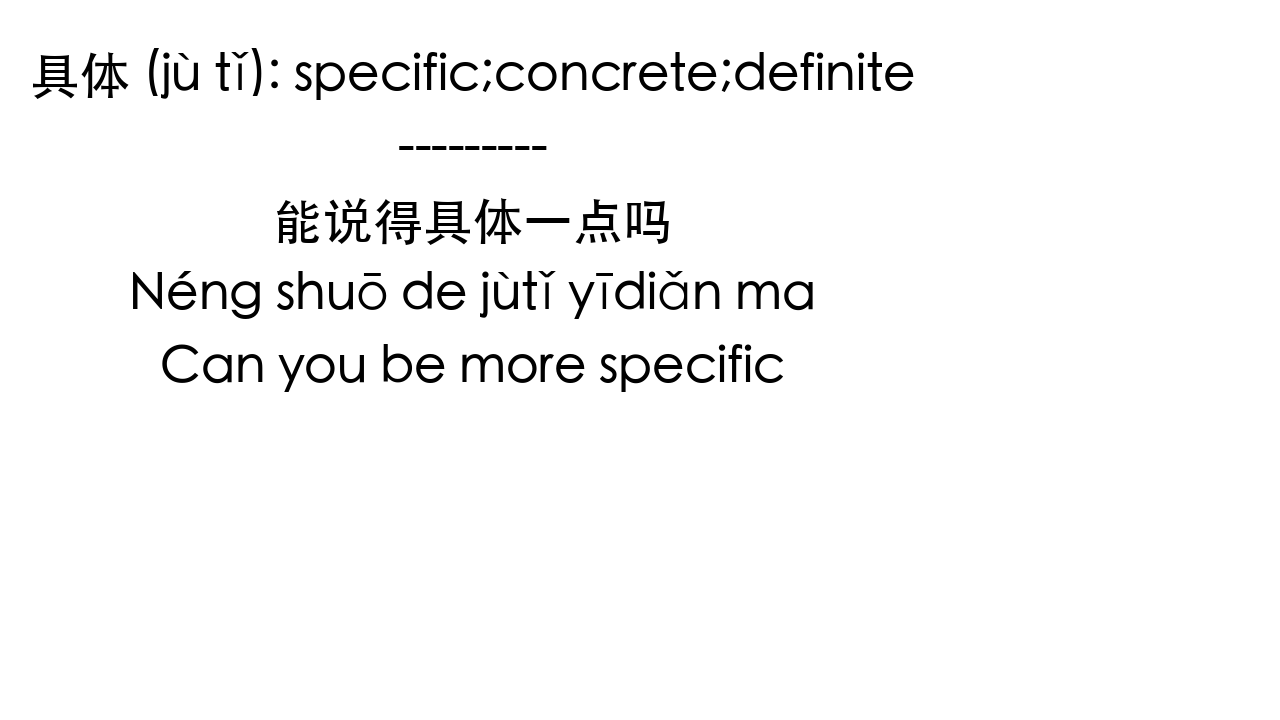

In [14]:
def create_component_words_text(row):
    component_words_text = f"{row['word1']}: {row['word1_english']}\n{row['word2']}: {row['word2_english']}"
    if not pd.isna(row['word3']):
        component_words_text += f"\n{row['word3']}: {row['word3_english']}"
    if not pd.isna(row['word4']):
        component_words_text += f"\n{row['word4']}: {row['word4_english']}"
    return component_words_text

def get_wrapped_text(text: str, font: ImageFont.ImageFont, line_length: int):
        # TODO: improve this for long strings of chinese characters without spaces
        new_lines = ['']
        for original_line in text.split('\n'):
            words_split = original_line.split(' ')
            for word_idx, word in enumerate(words_split):
                test_line = f'{new_lines[-1]} {word}'.strip()
                if word_idx == 0 and new_lines[-1] != '':
                    new_lines.append(word)
                elif font.getlength(test_line) <= line_length:
                    new_lines[-1] = test_line
                else:
                    new_lines.append(word)
        return '\n'.join(new_lines)


def create_text_clip(
        text, duration, timestamp_start, image_file_name
        , size=(1280, 720)
        , bg_color='white'
        , text_color='black'
        ):
    # Use textcip
    # clip_c = TextClip(text=f"{chinese}\n{pinyin}", font='Marker Felt', font_size=70, color=text_color, bg_color=bg_color, size=size, method='label', duration=duration_text_c)
    font = ImageFont.truetype(hanzi_font_path, 50)
    wrapped_text = get_wrapped_text(text, font, line_length=size[0]-60)

    img = Image.new("RGB", size, color=bg_color)
    draw = ImageDraw.Draw(img)
    draw.multiline_text(
        xy=(30, 50), text=wrapped_text, font=font
        , fill=text_color, spacing=30, align='center'
        )

    img_file_path = f"audio_files/img_for_video/{image_file_name}.png"
    img.save(img_file_path)
    return ImageClip(img_file_path, duration=duration).with_start(timestamp_start)


# Create all clips
clips = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    if not os.path.exists(f"audio_files/img_for_video/{rrow['recording_id']}"):
        os.mkdir(f"audio_files/img_for_video/{rrow['recording_id']}")
    clips[rrow['recording_name']] = []
    for idx, row in df_audio_durations[rrow['recording_name']].iterrows():
        if rrow['recording_id'] == '013':
            clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}", row['start_component_words'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
            component_words_text = create_component_words_text(row)
            clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}\n{component_words_text}", row['start_english'] - row['start_component_words'], row['start_component_words'], f"{rrow['recording_id']}/{row['chinese']}_component_words"))
            clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}\n{component_words_text}\n{row['english']}", row['start_sent'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_component_words_english"))
            clips[rrow['recording_name']].append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}", row['start_sent_english'] - row['start_sent'], row['start_sent'], f"{rrow['recording_id']}/{row['chinese']}_sentence"))
            clips[rrow['recording_name']].append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['end'] - row['start_sent_english'], row['start_sent_english'], f"{rrow['recording_id']}/{row['chinese']}_sentence_e"))
        
        elif rrow['recording_id'] == '006':
            clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}", row['start_component_words'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
            component_words_text = create_component_words_text(row)
            clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}\n{component_words_text}", row['start_english'] - row['start_component_words'], row['start_component_words'], f"{rrow['recording_id']}/{row['chinese']}_component_words"))
            clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}\n{component_words_text}\n{row['english']}", row['end'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_component_words_english"))
        
        elif rrow['recording_id'] == '001':
            clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']} ({row['pinyin']})", row['start_english'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
            clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']} ({row['pinyin']}): {row['english']}", row['start_sent'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_english"))
            clips[rrow['recording_name']].append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}", row['start_sent_english'] - row['start_sent'], row['start_sent'], f"{rrow['recording_id']}/{row['chinese']}_sentence"))
            clips[rrow['recording_name']].append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['end'] - row['start_sent_english'], row['start_sent_english'], f"{rrow['recording_id']}/{row['chinese']}_sentence_e"))
        
        elif rrow['recording_id'] == '012':
            clips[rrow['recording_name']].append(create_text_clip(f"{row['english']}", row['start_chinese'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_english"))
            clips[rrow['recording_name']].append(create_text_clip(f"{row['english']}\n{row['chinese']} ({row['pinyin']})", row['start_sent'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
            clips[rrow['recording_name']].append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['end'] - row['start_sent'], row['start_sent'], f"{rrow['recording_id']}/{row['chinese']}_sentence"))
        
        elif rrow['recording_id'] in ['004', '008', '010', '014']:
            clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}", row['start_english'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
            clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}\n{row['english']}", row['end'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_english"))
        
        elif rrow['recording_id'] in ['015']:
            clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']} ({row['pinyin']}): {row['english']}\n --------- \n{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['end'] - row['start'], row['start'], f"{rrow['recording_id']}/{row['chinese']}"))
        
        else:
            raise ValueError(f"Unknown vlaue of recording_id: {rrow['recording_id']}")
        
        if idx % 20 == 0:
            print(f'{rrow['recording_name']}; {idx}: {row["chinese"]}')

clips[rrow['recording_name']][3].display_in_notebook()

In [70]:
# img = Image.new("RGB", (780, 320))
# draw = ImageDraw.Draw(img)
# draw.multiline_text(xy=(30, 50), text=f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}"
#                     , font=ImageFont.truetype(hanzi_font_path, 30)
#                     , spacing=30
#                     , align='center'
#                     , fill='red'
#                     , direction='ltr'
#                     , stroke_width=8
#                     , stroke_fill='blue'
#                     )
# img.save("tmp.png")
# ImageClip("tmp.png", duration=1).with_start(0).display_in_notebook()

## 6b. Create video with audio

In [15]:
# Load audio
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    audio = AudioFileClip(f"audio_files/products/{rrow['recording_name']}.mp3")
    # Compare durations of audio and video
    all_clips_duration = sum(clip.duration for clip in clips[rrow['recording_name']])
    print(f"{rrow['recording_name']}: audio: {audio.duration:.3f}s, video: {all_clips_duration:.3f}s; difference: {audio.duration - all_clips_duration:.3f}s")

0904_012_efirst_csent_p1_1: audio: 1012.490s, video: 1012.433s; difference: 0.057s
0904_012_efirst_csent_p2_2: audio: 4619.860s, video: 4619.803s; difference: 0.057s
0904_012_efirst_csent_p3_3: audio: 2665.510s, video: 2665.456s; difference: 0.054s
0904_012_efirst_csent_p1_3_known2: audio: 3073.220s, video: 3073.168s; difference: 0.052s
0904_001_full_word_sent_p1_1: audio: 593.160s, video: 593.096s; difference: 0.064s
0904_001_full_word_sent_p2_2: audio: 5472.170s, video: 5472.099s; difference: 0.071s
0904_001_full_word_sent_p3_3: audio: 13896.220s, video: 13896.156s; difference: 0.064s
0904_004_word_only_p1_1: audio: 228.290s, video: 228.227s; difference: 0.063s
0904_004_word_only_p2_2: audio: 2132.710s, video: 2132.653s; difference: 0.057s
0904_004_word_only_p1_2_phrase: audio: 1488.720s, video: 1488.664s; difference: 0.056s
0904_004_word_only_p3_3_phrase: audio: 808.130s, video: 808.080s; difference: 0.050s
0904_006_ecombo_p1_2: audio: 9789.120s, video: 9789.058s; difference: 0.062s

In [ ]:
# NOTE: Issue with first, 012 liter
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    video_file_name = f"audio_files/products/videos/{rrow['recording_name']}_video.mp4"
    if os.path.exists(video_file_name):
        print(f"Video already exists: {video_file_name}, skipping...")
    else:
        video = CompositeVideoClip(clips[rrow['recording_name']], size=(1280,720))
        audio = AudioFileClip(f"audio_files/products/{rrow['recording_name']}.mp3")
        video.audio = audio
        video.duration = audio.duration
        video.write_videofile(video_file_name, fps=24)

!!!!!!!!! 0904_012_efirst_csent_p1_1 START
MoviePy - Building video audio_files/products/0904_012_efirst_csent_p1_1_video.mp4.
MoviePy - Writing audio in 0904_012_efirst_csent_p1_1_videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video audio_files/products/0904_012_efirst_csent_p1_1_video.mp4



MoviePy - Done !
MoviePy - video ready audio_files/products/0904_012_efirst_csent_p1_1_video.mp4
!!!!!!!!! 0904_012_efirst_csent_p1_1 DONE
!!!!!!!!! 0904_012_efirst_csent_p2_2 START
MoviePy - Building video audio_files/products/0904_012_efirst_csent_p2_2_video.mp4.
MoviePy - Writing audio in 0904_012_efirst_csent_p2_2_videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video audio_files/products/0904_012_efirst_csent_p2_2_video.mp4



MoviePy - Done !
MoviePy - video ready audio_files/products/0904_012_efirst_csent_p2_2_video.mp4
!!!!!!!!! 0904_012_efirst_csent_p2_2 DONE
!!!!!!!!! 0904_012_efirst_csent_p3_3 START
MoviePy - Building video audio_files/products/0904_012_efirst_csent_p3_3_video.mp4.
MoviePy - Writing audio in 0904_012_efirst_csent_p3_3_videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video audio_files/products/0904_012_efirst_csent_p3_3_video.mp4



frame_index:  22%|██▏       | 14000/63972 [04:29<16:49, 49.52it/s, now=None]